# 다중 회귀분석


***타겟 변수 : adr_1 변수에 대한 설명***

adr은 해당 레코드의 숙박팀의 1일 평균 사용금액을 말한다. : Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights

adr_1은 이를 총 숙박인원수로 나누어 1인당 1일 평균 사용금액을 계산해낸 파생변수이다.

: 해당 adr_1과 유의미한 양의 상관관계를 가지는 변수를 알아내어 1일당 고매출액의 마케팅 타겟을 선정하고,
ADR을 예측하는 모델을 설계하는 것이 목적




  #### 파생 가능 주제 : 
  
어떤 속성이 adr와 유의미한 상관관계를 가지는가? 
-> 어떤 속성을 가진 타겟을 마케팅 대상으로 선정해야 매출액을 증대시킬 수 있을까? 등

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

''''''
df_ht = pd.read_csv('hotel_bookings.csv')
''''''
df_ht_lr = df_ht.drop(['company','agent','reservation_status','reservation_status_date','country'
                       ,'arrival_date_day_of_month'
                       ,'arrival_date_week_number',
                       'previous_bookings_not_canceled'], axis = 1)


''''''
df_ht_lr = df_ht_lr.dropna()


''''''

''

In [74]:
df_ht_lr.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,2015,July,0,0,2,0.0,0,BB,Direct,Direct,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0
1,Resort Hotel,0,737,2015,July,0,0,2,0.0,0,BB,Direct,Direct,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0
2,Resort Hotel,0,7,2015,July,0,1,1,0.0,0,BB,Direct,Direct,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0
3,Resort Hotel,0,13,2015,July,0,1,1,0.0,0,BB,Corporate,Corporate,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0
4,Resort Hotel,0,14,2015,July,0,2,2,0.0,0,BB,Online TA,TA/TO,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1


# 전처리

In [75]:
# 취소한 데이터는 해당 모델에 무의미하다고 판단하여 제외
df_ht_lr = df_ht_lr[df_ht_lr['is_canceled'] == 0]

In [76]:
#1
df_ht_lrp = df_ht_lr[df_ht_lr['adults'] < 5]

#+ 2 수행을 위한 총 인원변수 추가
    #+ 10인 이상의 이상값 제거
df_ht_lrp['total_guests'] = df_ht_lr['adults'] + df_ht_lr['babies'] + df_ht_lr['children']
df_ht_lrp = df_ht_lrp[df_ht_lrp['total_guests'] < 10]
#2
df_ht_lrp['adr_1'] = df_ht_lrp['adr'] // df_ht_lrp['total_guests']

    #2+
df_ht_lrp = df_ht_lrp.replace([np.inf, -np.inf], np.nan)
df_ht_lrp = df_ht_lrp.dropna()


#3 adr_1 이 0보다 작거나 같은 경우, 무의미한 데이터로 간주하여 삭제한다. & 200초과인 경우 이상치로 간주하여 제거
df_ht_lrp = df_ht_lrp[df_ht_lrp['adr_1'] > 0]

df_ht_lrp = df_ht_lrp[df_ht_lrp['adr_1'] < 200] 



Text(0.5, 1.0, 'boxenplot on adr_1')

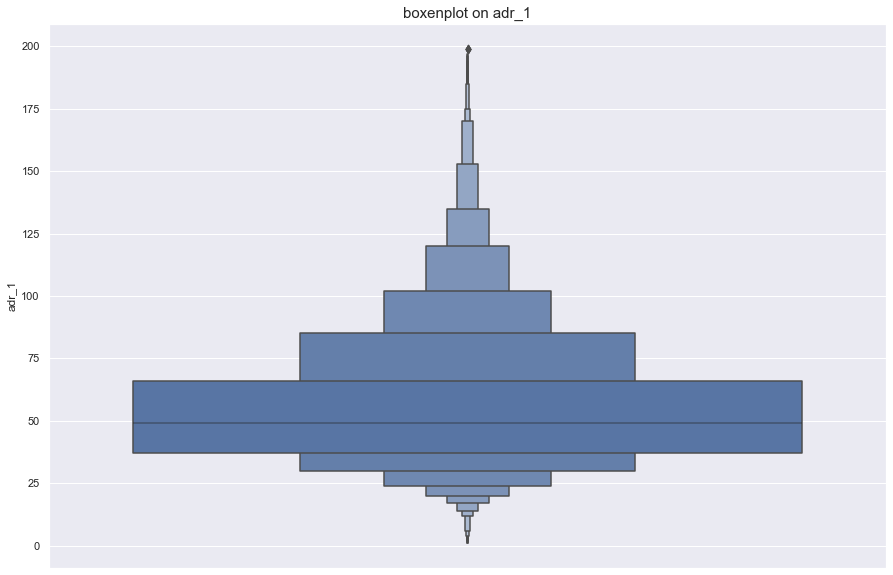

In [77]:
# adr_1의 분포를 보여주는 boxenplot
sns.boxenplot(data=df_ht_lrp, y='adr_1')

plt.title('boxenplot on adr_1',fontsize=15)

In [78]:
#불필요 변수 드랍
df_ht_lrp_mid = df_ht_lrp.drop(['previous_cancellations','reserved_room_type','days_in_waiting_list',
                                'is_canceled',
                                'adr'],
                               axis=1)

df_ht_lrp_mid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73288 entries, 2 to 119389
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hotel                        73288 non-null  object 
 1   lead_time                    73288 non-null  int64  
 2   arrival_date_year            73288 non-null  int64  
 3   arrival_date_month           73288 non-null  object 
 4   stays_in_weekend_nights      73288 non-null  int64  
 5   stays_in_week_nights         73288 non-null  int64  
 6   adults                       73288 non-null  int64  
 7   children                     73288 non-null  float64
 8   babies                       73288 non-null  int64  
 9   meal                         73288 non-null  object 
 10  market_segment               73288 non-null  object 
 11  distribution_channel         73288 non-null  object 
 12  is_repeated_guest            73288 non-null  int64  
 13  assigned_room_t

### correlation heatmap

Text(0.5, 1.0, 'Heatmap')

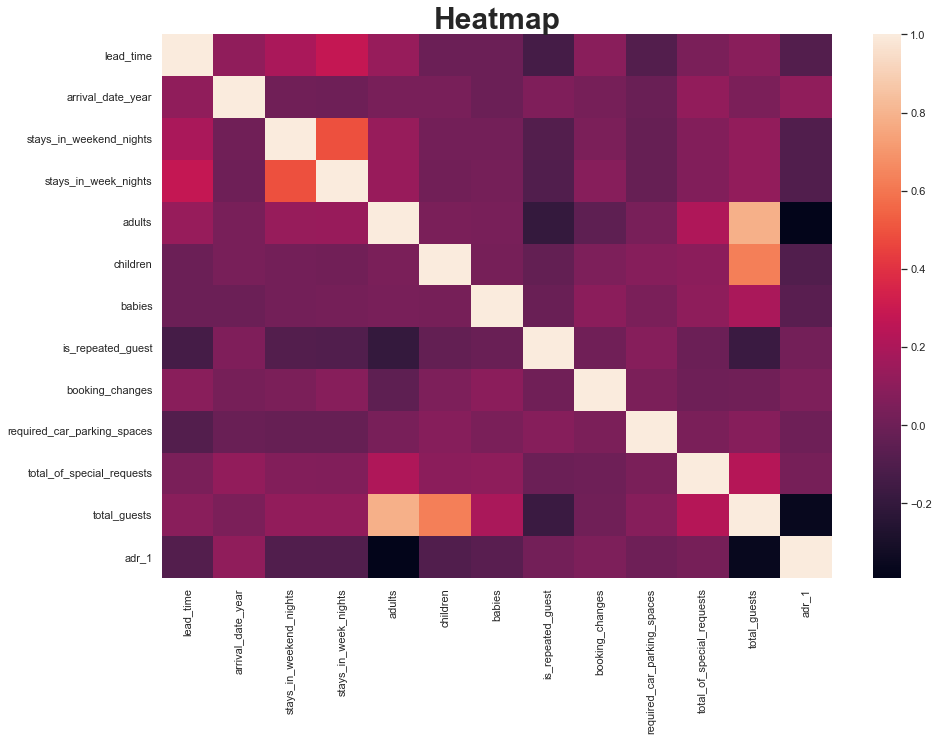

In [79]:
sns.set(rc = {'figure.figsize': (15,10)})
sns.heatmap(df_ht_lrp_mid.corr())
plt.title('Heatmap',fontsize=30,fontweight='bold')

### 더미변수 생성

In [80]:
# df_ht_lrp_fin = df_ht_lrp_mid.drop('country',axis=1)

# 더미화
df_lrp_fin = pd.get_dummies(data=df_ht_lrp_mid, 
                            columns=
                            ['hotel',
                             'arrival_date_year',
                             'arrival_date_month',
                             'meal',
                             'market_segment',
                             'distribution_channel',
                             'is_repeated_guest',
                             'assigned_room_type',
                             'booking_changes',
                             'deposit_type',
                             'customer_type',
                             'required_car_parking_spaces',
                             
                             ]
                            ,drop_first=True)

df_lrp_fin.columns.values

array(['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'adults', 'children', 'babies', 'total_of_special_requests',
       'total_guests', 'adr_1', 'hotel_Resort Hotel',
       'arrival_date_year_2016', 'arrival_date_year_2017',
       'arrival_date_month_August', 'arrival_date_month_December',
       'arrival_date_month_February', 'arrival_date_month_January',
       'arrival_date_month_July', 'arrival_date_month_June',
       'arrival_date_month_March', 'arrival_date_month_May',
       'arrival_date_month_November', 'arrival_date_month_October',
       'arrival_date_month_September', 'meal_FB', 'meal_HB', 'meal_SC',
       'meal_Undefined', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'distribution_channel_Direct',
       'distribution_channel_GDS', 'distribution_channel_TA/TO',
       'distribution_channel_Undefined'

## 다중선형모델

In [81]:
from sklearn.model_selection import train_test_split
X = df_lrp_fin.drop('adr_1',axis=1)
y = df_lrp_fin['adr_1']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.3, 
                                                    random_state=101)

In [82]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(X_train,y_train)

LinearRegression()

In [83]:
# 결정계수 / 회귀식 기울기 / 절편 게산

    #결정계수
r_square = lm.score(X_test, y_test)
print('R-square: ', r_square)
print('\n')

R-square:  0.5585725516335398




In [84]:
# 기울기
print('독립변수들의 기울기: ',lm.coef_)

# 절편
print('절편: ',lm.intercept_)

독립변수들의 기울기:  [-6.00258740e-02 -5.76644818e-01  3.76538642e-01 -1.25401254e+01
 -1.02798438e+00 -2.58036613e+00  1.19239224e+00 -1.61484759e+01
 -1.73466531e+01  8.61095609e+00  1.67228156e+01  2.27887020e+01
 -1.73642039e+00 -1.40326614e+01 -1.77152049e+01  1.85200211e+01
  1.19752801e+01 -1.03128716e+01  8.01383181e+00 -4.37690519e+00
  7.06766749e+00  1.67791565e+01  2.52239979e+01  1.33695378e+01
 -8.26021786e+00  2.21228818e+01 -4.94276731e+01 -2.21172030e+01
 -1.09970047e+01 -1.95236048e+01 -1.91238288e+01 -7.79639598e+00
  2.59224469e+00  3.56136247e+01 -1.21323674e+00 -3.67004410e+00
 -6.17421452e+00 -3.42183972e+00  9.50779035e+00  4.69167092e+00
  1.18872983e+01  1.68226699e+01  2.60205505e+01  3.15486725e+01
  2.89488354e+00  4.02209533e+00  2.56131054e+00  2.41397878e+00
  3.27540485e+00  5.21195298e+00  4.79829825e-03  8.18295762e+00
 -2.97908329e+00  3.05777714e+00  1.90138838e+00 -3.22206797e+00
 -4.70987228e+00 -5.32907052e-15  8.08510243e+00 -1.18938748e+01
 -2.82150095

### coefficient 확인

In [85]:
# lm.coef_
# X.columns
coeff_df = pd.DataFrame(lm.coef_, X.columns,columns=['Coefficient'])
print(coeff_df.sort_values(by='Coefficient', ascending=False).head(10))
print(coeff_df.sort_values(by='Coefficient', ascending=True).head(10))

                              Coefficient
distribution_channel_GDS        35.613625
assigned_room_type_H            31.548673
assigned_room_type_G            26.020550
meal_FB                         25.223998
arrival_date_month_August       22.788702
meal_Undefined                  22.122882
arrival_date_month_July         18.520021
assigned_room_type_F            16.822670
arrival_date_month_September    16.779157
arrival_date_year_2017          16.722816
                               Coefficient
market_segment_Complementary    -49.427673
market_segment_Corporate        -22.117203
required_car_parking_spaces_8   -22.046501
market_segment_Groups           -19.523605
market_segment_Offline TA/TO    -19.123829
arrival_date_month_January      -17.715205
hotel_Resort Hotel              -17.346653
total_guests                    -16.148476
arrival_date_month_February     -14.032661
adults                          -12.540125


In [86]:
# predict
predictions = lm.predict(X_test)

### 예측결과 : scatter plot

adr_1이 100이 넘어가는 케이스부터 예측률이 떨어지는 점을 볼 수 있다. <br>
실제 호텔 비즈니스에서 사전에 확보하여 예측에 투입 가능한 변수들만 사용하여 모델을 구성한 점을 미루어볼 떄, 이정도의 오차는 허용범위이며, 
충분히 유의미한 adr예측이라고 생각된다. 

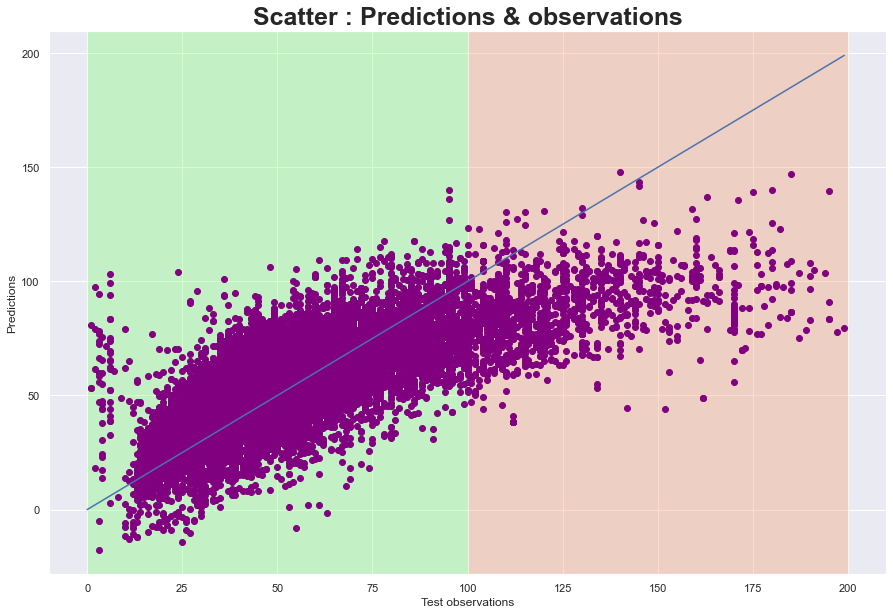

In [87]:

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(1,1,1)

## axes2
ax1.axvspan(0, 100, facecolor='#6cff5c', alpha=0.3)
ax1.axvspan(100, 200, facecolor='#f79159', alpha=0.3)

plt.scatter(x=y_test,y=predictions, c='purple')
plt.plot(range(200), range(200))
plt.title('Scatter : Predictions & observations',fontsize=25,fontweight='bold')
plt.xlabel('Test observations')
plt.ylabel('Predictions')
plt.show()

In [88]:
## compare the actual price with the predicted one in the test set

y_test1=y_test.to_frame()
y_test1['Predictions']=predictions
y_test1.head()

,adr_1,Predictions
95718,57.0,69.018238
18659,25.0,39.575182
32246,55.0,78.518949
86101,44.0,37.201705
20082,33.0,33.718968


### 예측결과 : Residual Histogram

잔차분포를 보여주는 그래프이다. 종모양으로 정규분포해 있다.

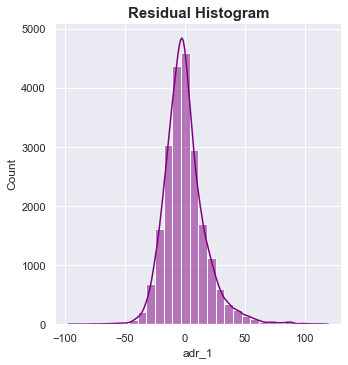

In [89]:
sns.displot((y_test-predictions),bins=30,color='purple',kde=True)
plt.title('Residual Histogram',fontsize=15,fontweight='bold')
plt.show()

In [90]:
# compute the erorrs and save them in the dataframe
y_test1['Error']=y_test1['Predictions']-y_test1['adr_1']
y_test1.head()

,adr_1,Predictions,Error
95718,57.0,69.018238,12.018238
18659,25.0,39.575182,14.575182
32246,55.0,78.518949,23.518949
86101,44.0,37.201705,-6.798295
20082,33.0,33.718968,0.718968


In [91]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 12.829927564167686
MSE: 317.4160262224553
RMSE: 17.816173164359828


### 정규성 검정 
1. qq plot - 결과 : 정규성을 어느정도 충족시키는 것으로 보인다.

Text(0.5, 1.0, 'QQ Plot')

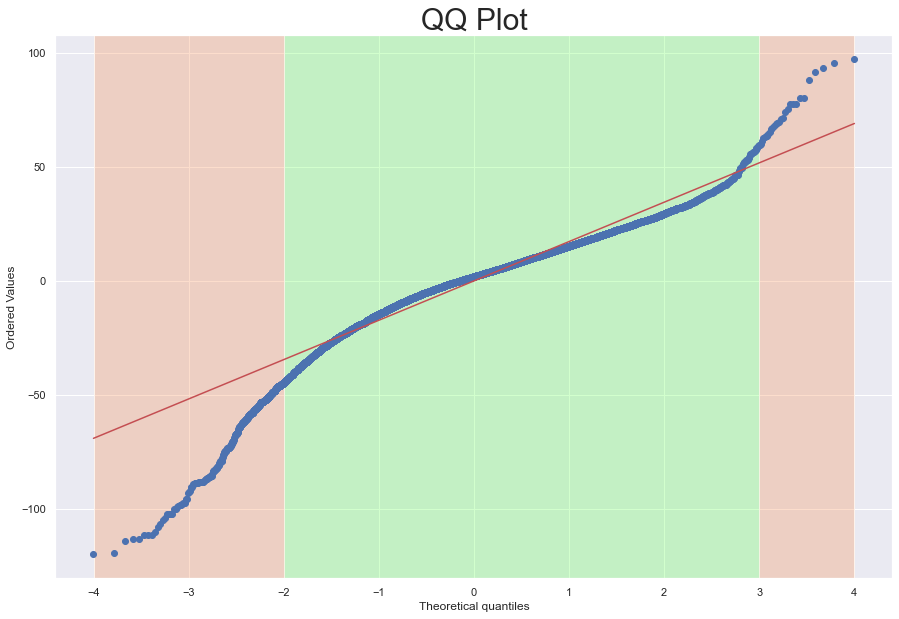

In [92]:
import scipy.stats as stats

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(1,1,1)
ax1.axvspan(-2,3, facecolor='#6cff5c', alpha=0.3)
ax1.axvspan(-4,-2, facecolor='#f79159', alpha=0.3)
ax1.axvspan(3,4, facecolor='#f79159', alpha=0.3)

stats.probplot(y_test1['Error'], plot=plt)

plt.title('QQ Plot', fontsize=30)

In [93]:
# ### 정규성 검정
# from scipy.stats import shapiro
# shapiro(data)

# 모델 검정

In [94]:
# OLS를 통한 종합 검토사항 확인

import statsmodels.api as sm

results = sm.OLS(y, sm.add_constant(X)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  adr_1   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     1257.
Date:                Sun, 05 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:01:43   Log-Likelihood:            -3.1496e+05
No. Observations:               73288   AIC:                         6.301e+05
Df Residuals:                   73215   BIC:                         6.307e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            111.9619      1.426     78.523      0.000     109.167     114.757
lead_time                         -0.0596      0.001    -65.178      0.000      -0.061      -0.058
stays_in_weekend_nights           -0.6357      0.078     -8.121      0.000      -0.789      -0.482
stays_in_week_nights               0.3832      0.043      8.943      0.000       0.299       0.467
adults                           -12.5637      0.205    -61.324      0.000     -12.965     -12.162
children                          -1.0254      0.220     -4.653      0.000      -1.457      -0.593
babies                            -2.7122      0.499     -5.438      0.000      -3.690      -1.735
total_of_special_requests          1.1651      0.090     12.898      0.000       0.988       1.342
total_guests                     -16.3013      0.178    -91.753      0.000     -16.650     -15.953
hotel_Resort Hotel               -17.4042      0.165   -105.536      0.000     -17.727     -17.081
arrival_date_year_2016             8.4427      0.212     39.817      0.000       8.027       8.858
arrival_date_year_2017            16.5405      0.255     64.789      0.000      16.040      17.041
arrival_date_month_August         22.7958      0.305     74.722      0.000      22.198      23.394
arrival_date_month_December       -2.0820      0.372     -5.590      0.000      -2.812      -1.352
arrival_date_month_February      -13.8141      0.334    -41.346      0.000     -14.469     -13.159
arrival_date_month_January       -17.7279      0.363    -48.886      0.000     -18.439     -17.017
arrival_date_month_July           18.5470      0.309     60.018      0.000      17.941      19.153
arrival_date_month_June           12.1429      0.319     38.068      0.000      11.518      12.768
arrival_date_month_March          -9.9814      0.315    -31.660      0.000     -10.599      -9.364
arrival_date_month_May             7.8656      0.310     25.384      0.000       7.258       8.473
arrival_date_month_November       -4.3145      0.364    -11.838      0.000      -5.029      -3.600
arrival_date_month_October         7.3004      0.336     21.737      0.000       6.642       7.959
arrival_date_month_September      16.9908      0.341     49.838      0.000      16.323      17.659
meal_FB                           26.6381      1.035     25.739      0.000      24.610      28.667
meal_HB                           13.4698      0.215     62.648      0.000      13.048      13.891
meal_SC                           -8.4364      0.255    -33.027      0.000      -8.937      -7.936
meal_Undefined                    22.3675      0.649     34.473      0.000      21.096      23.639
market_segment_Complementary     -47.6429      2.778    -17.149      0.000     -53.088     -42.198
market_segment


0. 표준 오차는 오차의 공분산 행렬이 올바르게 지정되었다고 확인됨.

1. 가장 작은 고유값이 4.13E-25로 강한 다중공선성 문제가 발견됨. 
         
         -> 해결이 요구됨

2. **F통계량의 P-VALUE**
   - Prob (F-statistic): 0.00 -> F통계량의 p-value가 0.05보다 작기에, 해당 회귀식은 회귀분석 모델 전체에 대해 통계적으로 의미가 있음

3. **T검정의 P-VALUE**
   - booking_changes_5,7,8,9,10,11,12,13,14,15,16,17,18은 유의수준 0.05보다 크기에 유의미하다고 판단할 수 없다. 즉 adr target판단에 유의한 근거가 되지 못한다. 
   - deposit_type_None Refund는 0.660으로 0.05보다 크기에 무의미하다고 판단.
   - customer_type_Transient 0.546은 0.05보다 크기에 무의미하다고 판단.
   - required_car_parking_spaces_2,3,8은 0.05보다 크기에 무의미하다고 판단.
   - distribution_channel_TA/TO는 0.076으로 0.05보다 크기에 무의미하다고 판단.
   - distribution_channel_Undefined는 0.823으로 0.05보다 크기에 무의미하다고 판단.
      
      -> 제거하여 모델 구성

4. R-squared 와 Adjusted R-squared를 확인해 볼 때, 0.553,0.552로 해당 모델은, 약 52%의 설명력을 가진다.

# VIF 및 T검정 결과를 바탕으로 X(독립변수들)의 변수선택법 실시를 통한 다중공선성 해결 시도

### VIF를 통한 다중공선성 확인

In [95]:
# # VIF ( 분산팽창요인 )을 통한 다중공선성 확인

pd.set_option('display.max_columns', None) ## 모든 열 출력
pd.set_option('display.max_rows', None) ## 모든 행 출력

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

lst = []

# 독립변수의 갯수 만큼 반복
for i in range(X.shape[1]):
    v = variance_inflation_factor(X.values, i) # 컬럼을 정수로 지정한다.
    lst.append(v)
    
vif["VIF Factor"] = lst
vif["features"] = X.columns
vif.head(5)

c:\Python3.10\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,2.867653,lead_time
1,2.629024,stays_in_weekend_nights
2,4.133619,stays_in_week_nights
3,inf,adults
4,inf,children


### VIF결과해석
VIF값은 독립변수들 간 의존성을 보여줌. 
보통 VIF값이 10을 넘는 경우 해당 독립변수와 타 독립변수 간 의존이 발생하고 있다고 보고 이것이 다중공선성을 발생시킴,<br>
둘 중 하나 혹은 둘 다 제거하여 이를 해결해야 함. 아래에 그것들을 표시해두었고 이들 중 몇을 제거하여 다시 다중공선성을 판단하고자 함

<img src='VIF1.png'> <img src='VIF2.png'> <img src='VIF3.png'>



## 리모델링 1. VIF값 10 이상 값 중 선별 제거 + T검정 기준치 탈락값 제거 실시 : X1

#### T검정 제거목록

1.  booking_changes 일괄 제거
2. deposit_type_None Refund 제거
3. customer_type_Transient 제거
4. required_car_parking_spaces_2,3,8 제거
5. distribution_channel_TA/TO 제거
6. dsitribution_channel_Undefined 제거

#### VIF 결과에 따른 제거목록

1. total_guests <-> adults / children / babies 
2. market_segment_Direct <-> distribution_channel_Direct
3.market_segment_Groups 제거
4. market_segment_Offline TA/TO 제거
5. market_segment_Online TA <-> distribution_channel_TA/TO(T검정에도 탈락하므로 얘 제거)
6. customer_type_Transient 제거 



In [96]:
X.columns.values
X1 = X.drop(['booking_changes_1', 'booking_changes_2', 'booking_changes_3',
       'booking_changes_4', 'booking_changes_5', 'booking_changes_6',
       'booking_changes_7', 'booking_changes_8', 'booking_changes_9',
       'booking_changes_10', 'booking_changes_11', 'booking_changes_12',
       'booking_changes_13', 'booking_changes_14', 'booking_changes_15',
       'booking_changes_16', 'booking_changes_17', 'booking_changes_18',
       'deposit_type_Non Refund', 'customer_type_Transient',
       'required_car_parking_spaces_2','required_car_parking_spaces_3','required_car_parking_spaces_8',
       'distribution_channel_TA/TO','distribution_channel_Undefined',
       'assigned_room_type_K',
       'total_guests',
       'market_segment_Direct','market_segment_Groups',
       'customer_type_Transient'
       ],axis=1)

### VIF와 T-val을 고려한 리모델링 및 결과 확인

In [97]:

# OLS를 통한 종합 검토사항 확인
import statsmodels.api as sm

results = sm.OLS(y, sm.add_constant(X1)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  adr_1   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     2021.
Date:                Sun, 05 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:03:01   Log-Likelihood:            -3.1533e+05
No. Observations:               73288   AIC:                         6.308e+05
Df Residuals:                   73243   BIC:                         6.312e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            95.0080      0.486    195.525      0.000      94.056      95.960
lead_time                        -0.0614      0.001    -67.596      0.000      -0.063      -0.060
stays_in_weekend_nights          -0.6006      0.079     -7.645      0.000      -0.755      -0.447
stays_in_week_nights              0.4325      0.043     10.148      0.000       0.349       0.516
adults                          -29.1952      0.151   -193.157      0.000     -29.491     -28.899
children                        -17.2745      0.198    -87.399      0.000     -17.662     -16.887
babies                          -17.7963      0.659    -27.008      0.000     -19.088     -16.505
total_of_special_requests         1.2730      0.090     14.096      0.000       1.096       1.450
hotel_Resort Hotel              -17.6780      0.164   -107.655      0.000     -18.000     -17.356
arrival_date_year_2016            8.7758      0.209     42.081      0.000       8.367       9.185
arrival_date_year_2017           16.9705      0.253     67.180      0.000      16.475      17.466
arrival_date_month_August        23.0476      0.306     75.347      0.000      22.448      23.647
arrival_date_month_December      -2.0378      0.373     -5.456      0.000      -2.770      -1.306
arrival_date_month_February     -13.9653      0.335    -41.664      0.000     -14.622     -13.308
arrival_date_month_January      -17.9369      0.364    -49.284      0.000     -18.650     -17.224
arrival_date_month_July          18.7201      0.310     60.404      0.000      18.113      19.328
arrival_date_month_June          12.2609      0.320     38.312      0.000      11.634      12.888
arrival_date_month_March        -10.1761      0.316    -32.178      0.000     -10.796      -9.556
arrival_date_month_May            7.7621      0.311     24.961      0.000       7.153       8.372
arrival_date_month_November      -4.2984      0.365    -11.777      0.000      -5.014      -3.583
arrival_date_month_October        7.3078      0.335     21.799      0.000       6.651       7.965
arrival_date_month_September     17.0409      0.342     49.832      0.000      16.371      17.711
meal_FB                          25.8434      1.036     24.934      0.000      23.812      27.875
meal_HB                          13.5011      0.215     62.922      0.000      13.081      13.922
meal_SC                          -8.5681      0.257    -33.400      0.000      -9.071      -8.065
meal_Undefined                   20.6611      0.643     32.108      0.000      19.400      21.922
market_segment_Complementary    -35.0649      2.397    -14.627      0.000     -39.763     -30.366
market_segment_Corporate         -3.9348      0.383    -10.280      0.000      -4.685      -3.185
market_segment_Offline TA/TO     -1.8628     

리모델링 결과 t검정 값의 문제는 해결되었음을 확인

#### but
ref: https://datascienceschool.net/03%20machine%20learning/04.03%20%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81.html

조건수(conditiona number)가 15100으로 너무 큽니다. 
강한 다중공선성(multicollinearity)이나 다른 수치적 문제가 있을 수 있습니다.

-> 행렬의 조건수(conditional number)는 가장 큰 고유치와 가장 작은 고유치의 비율을 뜻한다. 회귀분석에서는 공분산행렬 XTX의 가장 큰 고유치와 가장 작은 고유치의 비율이 된다.

---
### 회귀분석과 조건수
회귀분석에서 조건수가 커지는 경우는 크게 두 가지가 있다.

1. 변수들의 단위 차이로 인해 숫자의 스케일이 크게 달라지는 경우. 이 경우에는 스케일링(scaling)으로 해결한다.

2. 다중 공선성 즉, 상관관계가 큰 독립 변수들이 있는 경우, 이 경우에는 변수 선택이나 PCA를 사용한 차원 축소 등으로 해결한다.
---

다중공선성이 해결되지 않았는지 VIF를 통해 다시한번 확인해보자


In [98]:
# # VIF ( 분산팽창요인 )을 통한 다중공선성 확인

pd.set_option('display.max_columns', None) ## 모든 열 출력
pd.set_option('display.max_rows', None) ## 모든 행 출력

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

lst = []

# 독립변수의 갯수 만큼 반복
for i in range(X1.shape[1]):
    v = variance_inflation_factor(X1.values, i) # 컬럼을 정수로 지정한다.
    lst.append(v)
    
vif["VIF Factor"] = lst
vif["features"] = X1.columns
vif.head(100)

,VIF Factor,features
0,2.813343,lead_time
1,2.615044,stays_in_weekend_nights
2,4.046897,stays_in_week_nights
3,13.794393,adults
4,1.470100,children
5,1.036888,babies
6,2.248558,total_of_special_requests
7,2.337147,hotel_Resort Hotel
8,4.211767,arrival_date_year_2016
9,4.139692,arrival_date_year_2017


## 리모델링2 : X2

        total_guests 파생변수를 삭제하여 adults,children,baby의 VIF값이 infinite에서 많이 개선된 것으로 보이지만, 여전히 adults의 VIF가 10을 넘기므로 해당 변수를 삭제하여 다시 리모델링 실시해보자
        
        -> 리모델링 반복 시행하여 아래와 같은 드랍목록이 만들어짐

In [99]:
X.columns.values
X2 = X1.drop(['adults','market_segment_Online TA','deposit_type_Refundable','customer_type_Group',
              'total_of_special_requests','arrival_date_month_November',
              'assigned_room_type_B','assigned_room_type_I','assigned_room_type_C','assigned_room_type_D'
       ],axis=1)

# VIF와 T-val을 고려한 리모델링 및 결과 확인

In [100]:

# OLS를 통한 종합 검토사항 확인
import statsmodels.api as sm

results = sm.OLS(y, sm.add_constant(X2)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  adr_1   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     990.7
Date:                Sun, 05 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:03:22   Log-Likelihood:            -3.3060e+05
No. Observations:               73288   AIC:                         6.613e+05
Df Residuals:                   73253   BIC:                         6.616e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            50.1463      0.341    147.228      0.000      49.479      50.814
lead_time                        -0.0766      0.001    -69.142      0.000      -0.079      -0.074
stays_in_weekend_nights          -1.1749      0.097    -12.171      0.000      -1.364      -0.986
stays_in_week_nights              0.1497      0.052      2.859      0.004       0.047       0.252
children                        -13.2161      0.237    -55.846      0.000     -13.680     -12.752
babies                          -17.9781      0.805    -22.345      0.000     -19.555     -16.401
hotel_Resort Hotel              -14.6665      0.195    -75.240      0.000     -15.049     -14.284
arrival_date_year_2016            8.7865      0.250     35.082      0.000       8.296       9.277
arrival_date_year_2017           17.6634      0.297     59.479      0.000      17.081      18.245
arrival_date_month_August        21.0142      0.326     64.439      0.000      20.375      21.653
arrival_date_month_December      -1.1442      0.409     -2.797      0.005      -1.946      -0.342
arrival_date_month_February     -12.6173      0.377    -33.488      0.000     -13.356     -11.879
arrival_date_month_January      -14.0493      0.416    -33.801      0.000     -14.864     -13.235
arrival_date_month_July          16.8867      0.335     50.386      0.000      16.230      17.544
arrival_date_month_June          13.4147      0.355     37.756      0.000      12.718      14.111
arrival_date_month_March         -8.7916      0.350    -25.133      0.000      -9.477      -8.106
arrival_date_month_May            9.0351      0.343     26.318      0.000       8.362       9.708
arrival_date_month_October        9.5381      0.355     26.840      0.000       8.842      10.235
arrival_date_month_September     18.5870      0.365     50.934      0.000      17.872      19.302
meal_FB                          20.2580      1.275     15.889      0.000      17.759      22.757
meal_HB                          12.2092      0.264     46.330      0.000      11.693      12.726
meal_SC                          -6.8119      0.308    -22.103      0.000      -7.416      -6.208
meal_Undefined                   15.1858      0.788     19.277      0.000      13.642      16.730
market_segment_Complementary    -29.3724      2.948     -9.963      0.000     -35.151     -23.594
market_segment_Corporate          3.6939      0.391      9.446      0.000       2.927       4.460
market_segment_Offline TA/TO     -7.4746      0.220    -33.960      0.000      -7.906      -7.043
distribution_channel_Direct       2.8844      0.241     11.977      0.000       2.412       3.356
distribution_channel_GDS         57.3122      1.812     31.631      0.000      53.761      60.864
is_repeated_guest_1               1.0089     

In [101]:
# VIF ( 분산팽창요인 )을 통한 다중공선성 확인

pd.set_option('display.max_columns', None) ## 모든 열 출력
pd.set_option('display.max_rows', None) ## 모든 행 출력

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

lst = []

# 독립변수의 갯수 만큼 반복
for i in range(X2.shape[1]):
    v = variance_inflation_factor(X2.values, i) # 컬럼을 정수로 지정한다.
    lst.append(v)
    
vif["VIF Factor"] = lst
vif["features"] = X2.columns
vif.head(100)

,VIF Factor,features
0,2.748242,lead_time
1,2.591541,stays_in_weekend_nights
2,3.846821,stays_in_week_nights
3,1.391350,children
4,1.019344,babies
5,2.162957,hotel_Resort Hotel
6,2.949650,arrival_date_year_2016
7,3.087290,arrival_date_year_2017
8,1.497153,arrival_date_month_August
9,1.184552,arrival_date_month_December


리모델링 끝에 VIF와 T-VAL을 충족하는 모형이 만들어졌으나 여전히 다중공선성을 내포하고 있음을 알려줌

Notes: <br>
[2] The condition number is large, 4.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

**-> 변수선택은 모두 시행해보았으니 정규화를 통해 해결해야 할 것으로 확인**

## 리모델링3: Feautures의 정규화를 통한 다중공선성 해결 시도
지금까지의 리모델링 및 전처리 과정을 거쳐온 독립변수 목록인 X / X1 / X2에 각각 다중공선성 해결을 위한 스케일링을 적용해본 결과

        1. X로의 스케일링 적용은 다중공선성 문제가 해결되지 않았고
        2. X2로의 스케일링 적용은 R_Squared가 0.3가량으로 설명력이 낮았다.

        3. 하지만 X1의 스케일링 적용은 약 0.55 가량의 설명력을 보존한 채 다중공선성도 해결해냈으므로 X1으로의 스케일링 적용으로 마지막 모델을 결정하도록 한다.

In [129]:

from sklearn.preprocessing import StandardScaler

# Standardization 평균 0 / 분산 1
scaler = StandardScaler()   

# 교차검증시
scaler.fit(X1)
X1 = scaler.transform(X1)



# OLS를 통한 종합 검토사항 확인
import statsmodels.api as sm

results = sm.OLS(y, sm.add_constant(X1)).fit()
results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  adr_1   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     2021.
Date:                Sun, 05 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:36:31   Log-Likelihood:            -3.1533e+05
No. Observations:               73288   AIC:                         6.308e+05
Df Residuals:                   73243   BIC:                         6.312e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.2403      0.066    836.108      0.000      55.111      55.370
x1            -5.6046      0.083    -67.596      0.000      -5.767      -5.442
x2            -0.5919      0.077     -7.645      0.000      -0.744      -0.440
x3             0.8195      0.081     10.148      0.000       0.661       0.978
x4           -14.6196      0.076   -193.157      0.000     -14.768     -14.471
x5            -6.7800      0.078    -87.399      0.000      -6.932      -6.628
x6            -1.8082      0.067    -27.008      0.000      -1.939      -1.677
x7             1.0604      0.075     14.096      0.000       0.913       1.208
x8            -8.6029      0.080   -107.655      0.000      -8.760      -8.446
x9             4.3857      0.104     42.081      0.000       4.181       4.590
x10            8.0044      0.119     67.180      0.000       7.771       8.238
x11            7.3621      0.098     75.347      0.000       7.171       7.554
x12           -0.4737      0.087     -5.456      0.000      -0.644      -0.304
x13           -3.5989      0.086    -41.664      0.000      -3.768      -3.430
x14           -4.0759      0.083    -49.284      0.000      -4.238      -3.914
x15            5.7580      0.095     60.404      0.000       5.571       5.945
x16            3.4344      0.090     38.312      0.000       3.259       3.610
x17           -2.8920      0.090    -32.178      0.000      -3.068      -2.716
x18            2.2715      0.091     24.961      0.000       2.093       2.450
x19           -1.0339      0.088    -11.777      0.000      -1.206      -0.862
x20            2.1081      0.097     21.799      0.000       1.919       2.298
x21            4.7571      0.095     49.832      0.000       4.570       4.944
x22            1.6637      0.067     24.934      0.000       1.533       1.794
x23            4.4904      0.071     62.922      0.000       4.351       4.630
x24           -2.4318      0.073    -33.400      0.000      -2.575      -2.289
x25            2.2083      0.069     32.108      0.000       2.073       2.343
x26           -0.9689      0.066    -14.627      0.000      -1.099      -0.839
x27           -0.9168      0.089    -10.280      0.000      -1.092      -0.742
x28           -0.7626      0.112     -6.815      0.000      -0.982      -0.543
x29            4.5754      0.143     31.946      0.000       4.295       4.856
x30            3.2696      0.109     30.003      0.000       3.056       3.483
x31            1.6118      0.067     24.230      0.000       1.481       1.742
x32           -1.0289      0.073    -14.009      0.000      -1.173      -0.885
x33           -0.4099      0.067     -6.084      0.000      -0.542      -0.278
x34            1.5565      0.071     22.048      0.000       1.418       1.695
x35            2.1222      0.073     29.106      0.000       1.979       2.265
x3

Chi^2       : 15732.739
P-value     :  0.000


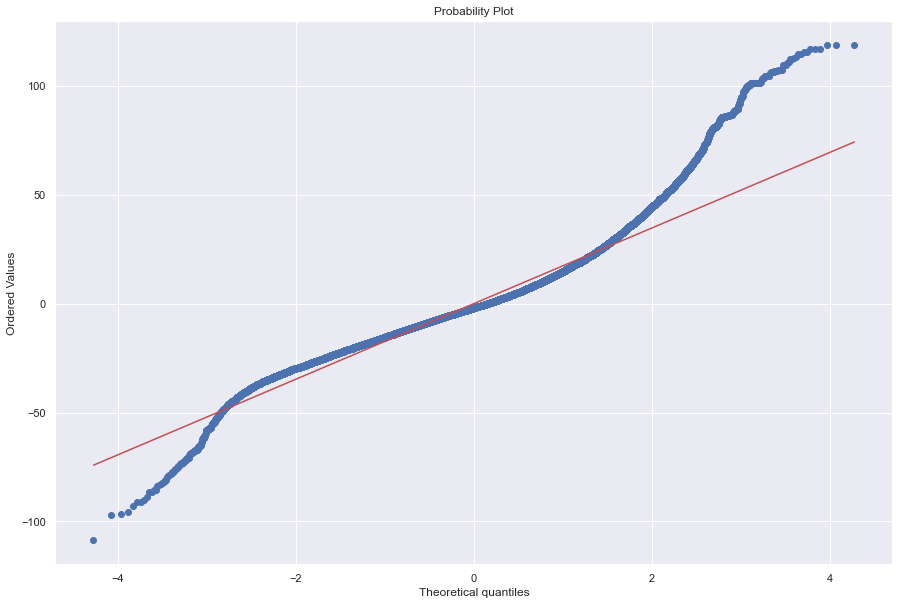

In [132]:
import scipy as sp

test = sm.stats.omni_normtest(results.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)
    
sp.stats.probplot(results.resid, plot=plt)
plt.show()

##### -> 해당 모형의 잔차가 정규성을 만족하지 않는 것으로 보임

In [115]:
############
from sklearn.model_selection import train_test_split
X = df_lrp_fin.drop('adr_1',axis=1)
y = df_lrp_fin['adr_1']

#
X1 = X.drop(['booking_changes_1', 'booking_changes_2', 'booking_changes_3',
       'booking_changes_4', 'booking_changes_5', 'booking_changes_6',
       'booking_changes_7', 'booking_changes_8', 'booking_changes_9',
       'booking_changes_10', 'booking_changes_11', 'booking_changes_12',
       'booking_changes_13', 'booking_changes_14', 'booking_changes_15',
       'booking_changes_16', 'booking_changes_17', 'booking_changes_18',
       'deposit_type_Non Refund', 'customer_type_Transient',
       'required_car_parking_spaces_2','required_car_parking_spaces_3','required_car_parking_spaces_8',
       'distribution_channel_TA/TO','distribution_channel_Undefined',
       'assigned_room_type_K',
       'total_guests',
       'market_segment_Direct','market_segment_Groups',
       'customer_type_Transient'
       ],axis=1)

#########
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X1, 
                                                    y,
                                                    test_size=0.3, 
                                                    random_state=101)

#####
#스케일링
from sklearn.preprocessing import StandardScaler

# Standardization 평균 0 / 분산 1
scaler = StandardScaler()   

# 교차검증시
scaler.fit(X_train2)
X_train2 = scaler.transform(X_train2)
X_test2 = scaler.transform(X_test2)

#####
lm2 = LinearRegression()

lm2.fit(X_train2,y_train2)

# 결정계수 / 회귀식 기울기 / 절편 게산

    #결정계수
r_square = lm2.score(X_test2, y_test2)
print('R-square: ', r_square)
print('\n')

# 기울기
print('독립변수들의 기울기: ',lm2.coef_)

# 절편
print('절편: ',lm2.intercept_)

# lm.coef_
# X.columns
coeff_df = pd.DataFrame(lm2.coef_, X1.columns,columns=['Coefficient'])
print(coeff_df.sort_values(by='Coefficient', ascending=False).head(10))
print(coeff_df.sort_values(by='Coefficient', ascending=True).head(10))

# predict
predictions2 = lm2.predict(X_test2)



R-square:  0.55414883672813


독립변수들의 기울기:  [ -5.63437639  -0.53539469   0.80235834 -14.58545115  -6.72794122
  -1.76812505   1.06862655  -8.57492901   4.49208401   8.11958071
   7.37549732  -0.38665941  -3.63226382  -4.04349791   5.74898244
   3.41252431  -2.98726813   2.32082286  -1.03937748   2.06558884
   4.68730571   1.58263421   4.46366921  -2.37983472   2.20598031
  -1.04029981  -0.99695286  -0.77485273   4.46528469   3.33047503
   1.63165798  -1.07287063  -0.40086381   1.59266841   2.09545493
   3.26579522   3.23823714   3.94172901   2.51617113   0.16254695
   0.26327962  -0.23251795   1.06482322   1.11323728]
절편:  55.20141907565154
                              Coefficient
arrival_date_year_2017           8.119581
arrival_date_month_August        7.375497
arrival_date_month_July          5.748982
arrival_date_month_September     4.687306
arrival_date_year_2016           4.492084
market_segment_Online TA         4.465285
meal_HB                          4.463669
assigned_room_ty

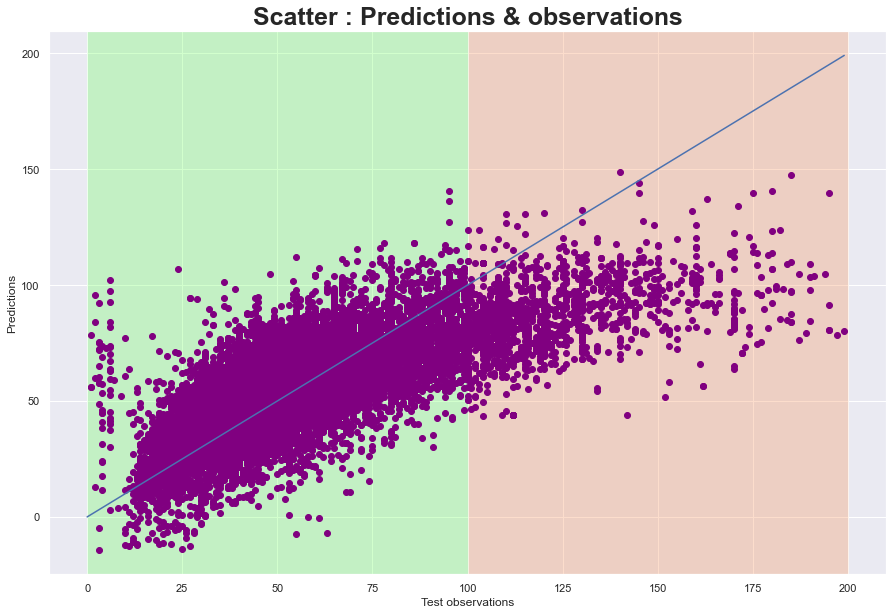

In [116]:

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(1,1,1)

## axes2
ax1.axvspan(0, 100, facecolor='#6cff5c', alpha=0.3)
ax1.axvspan(100, 200, facecolor='#f79159', alpha=0.3)

plt.scatter(x=y_test2,y=predictions2, c='purple')
plt.plot(range(200), range(200))
plt.title('Scatter : Predictions & observations',fontsize=25,fontweight='bold')
plt.xlabel('Test observations')
plt.ylabel('Predictions')
plt.show()

In [118]:
# compute the erorrs and save them in the dataframe
y_test3['Error']=y_test3['Predictions']-y_test3['adr_1']
y_test3.head()

,adr_1,Predictions,Error
95718,57.0,68.385919,11.385919
18659,25.0,39.509684,14.509684
32246,55.0,82.145572,27.145572
86101,44.0,37.350624,-6.649376
20082,33.0,33.939311,0.939311


In [119]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test2, predictions2))
print('MSE:', metrics.mean_squared_error(y_test2, predictions2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test2, predictions2)))

MAE: 12.932180092352676
MSE: 320.5969747828868
RMSE: 17.905221997587372


Text(0.5, 1.0, 'QQ Plot')

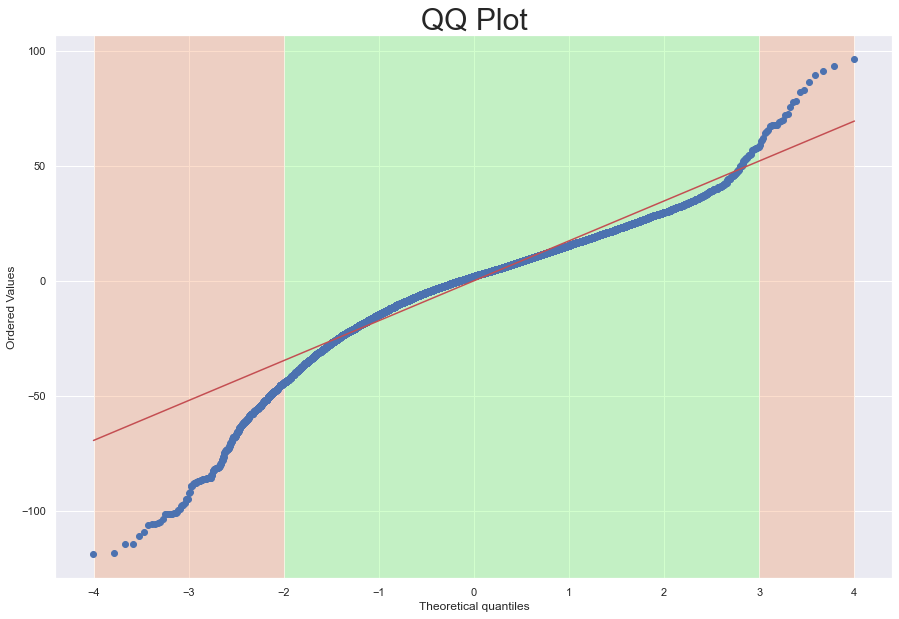

In [126]:
import scipy.stats as stats

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(1,1,1)
ax1.axvspan(-2,3, facecolor='#6cff5c', alpha=0.3)
ax1.axvspan(-4,-2, facecolor='#f79159', alpha=0.3)
ax1.axvspan(3,4, facecolor='#f79159', alpha=0.3)

stats.probplot(y_test3['Error'], plot=plt)

plt.title('QQ Plot', fontsize=30)

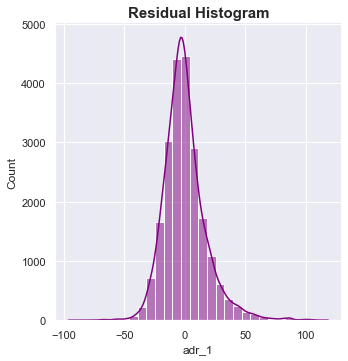

In [ ]:
## compare the actual price with the predicted one in the test set

y_test3=y_test2.to_frame()
y_test3['Predictions']=predictions2
y_test3.head()

sns.displot((y_test2-predictions2),bins=30,color='purple',kde=True)
plt.title('Residual Histogram',fontsize=15,fontweight='bold')
plt.show()

In [127]:
### 정규성 검정

from scipy.stats import shapiro
shapiro(y_test3['Predictions']-y_test3['adr_1'])

c:\Python3.10\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9401586651802063, pvalue=0.0)

ref: https://brunch.co.kr/@gimmesilver/65

" 지금까지 보셨듯이 회귀 분석을 할 때는 이렇게 여러 가지 고려해야할 사항들이 많습니다. 간혹 어떤 자료를 보면 잔차의 정규성, 독립성, 등분산성 같은 조건을 마치 수학적으로 자명한 규칙이라거나 뭔가 심오한 원리인냥 과도한 의미를 부여하는 경우가 있습니다. 하지만 이런 잔차에 대한 가정들을 만족하지 못한다고 해서 회귀 분석이 불가능한 것은 아닙니다. 근로자 연봉 사례에서도 보시다시피 전체 연봉 분포가 크게 평향되어 있더라도 평균 연봉을 구하는데 아무런 문제가 없습니다."

"현실에서는 확보할 수 있는 데이터에 한계가 있기 때문이죠."